In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params, pycortex_plot_utils
plot_utils.set_all_font_sizes(20)
from utils import roi_utils, default_paths, stats_utils

In [13]:
# Load results of the fitting procedure

subjects = [1]
n_subjects = len(subjects)

fitting_type = 'all_coco'
# fitting_type = 'all_coco_categ'
# fitting_type = 'all_coco_things'
# fitting_type = 'all_coco_stuff'

out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, n_from_end=0, verbose=False) for ss in subjects]
fig_save_folder=None
roi_def = roi_utils.multi_subject_roi_def(subjects)
roi_names =roi_def.roi_names
skip_inds = [4,5,7,10,11,15,16,21, 23]
areas2plot = np.arange(len(roi_names))
areas2plot = areas2plot[~np.isin(areas2plot, skip_inds)]



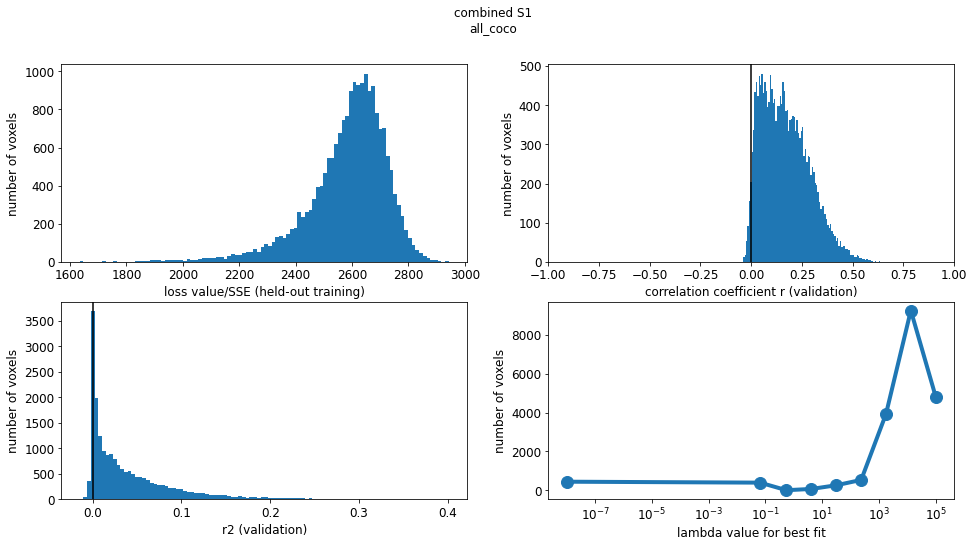

In [3]:
plot_utils.set_all_font_sizes(fs = 12)
summary_plots.plot_perf_summary(fitting_type, out, fig_save_folder=fig_save_folder)

In [21]:
# Make a barplot for variance partition across all ROIs and subjects

r2_thresh = 0.01

pp0 = 0
pp1 = 1
pp2 = 2

name1 = out[0]['partial_version_names'][pp1].split('just_')[1]
name2 = out[0]['partial_version_names'][pp2].split('just_')[1]

ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']

colors = cm.plasma(np.linspace(0,1,4))
colors = np.flipud(colors)
colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[[1,2],:], np.array([[0.2, 0.2, 0.2, 1]])), axis=0)

vals = np.zeros((n_subjects, len(areas2plot), 4))

for si, ss in enumerate(subjects):
    
    val_r2 = out[si]['val_r2']    
    inds2use = val_r2[:,0]>r2_thresh
    shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])
    var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

    for ri, rr in enumerate(areas2plot):

        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(rr) & inds2use
        if np.sum(inds_this_roi)==0:
            print('subj %d %s has no voxels'%(ss, roi_names[rr]))
            vals[si,ri,:] = np.nan
            
        vals[si,ri,:] = np.mean(var_expl[inds_this_roi,:], axis=0)
        
mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

legend_separate=True
title='%s\n%s\nShowing all voxels with R2>%.2f'%(summary_plots.get_substr(out), \
                                                                       fitting_type, r2_thresh)

plot_utils.set_all_font_sizes(fs = 16)

plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=colors, space=0.3, \
                xticklabels=np.array(roi_names)[areas2plot], ylabel='Var explained', \
                ylim=[-0.02, 0.16], title=title, horizontal_line_pos=0,\
                legend_labels=ve_names, \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))





IndexError: list index out of range

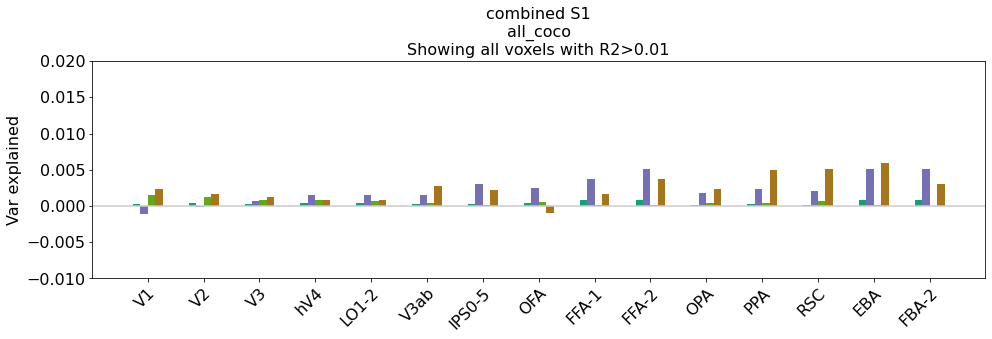

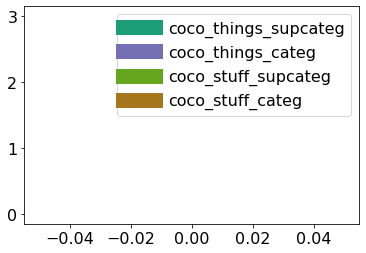

In [16]:
# Make a barplot for variance partition across all ROIs and subjects
roi_names =roi_def.roi_names
skip_inds = [4,5,7,10,11,15,16,21,23]
areas2plot = np.arange(len(roi_names))
areas2plot = areas2plot[~np.isin(areas2plot, skip_inds)]

r2_thresh = 0.01

# each of these indices is one feature set left out at a time.
ppinds = [2,4,6,8]
ve_names = [out[0]['partial_version_names'][pp].split('leave_out_semantic_')[1] for pp in ppinds]

colors = cm.Dark2(np.linspace(0,1,5))

vals = np.zeros((n_subjects, len(areas2plot), 4))

for si, ss in enumerate(subjects):
    
    val_r2 = out[si]['val_r2']    
    inds2use = val_r2[:,0]>r2_thresh
    var_expl = np.tile(val_r2[:,0:1], [1,4]) - val_r2[:,ppinds]

    for ri, rr in enumerate(areas2plot):
        
        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(rr) & inds2use
        if np.sum(inds_this_roi)==0:
            print('subj %d %s has no voxels'%(ss, roi_names[rr]))
            vals[si,ri,:] = np.nan
        vals[si,ri,:] = np.mean(var_expl[inds_this_roi,:], axis=0)
        
mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

legend_separate=True
title='%s\n%s\nShowing all voxels with R2>%.2f'%(summary_plots.get_substr(out), \
                                                                       fitting_type, r2_thresh)

plot_utils.set_all_font_sizes(fs = 16)
plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=colors, space=0.3, \
                xticklabels=np.array(roi_names)[areas2plot], ylabel='Var explained', \
                ylim=[-0.01, 0.02], title=title, horizontal_line_pos=0,\
                legend_labels=ve_names, \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))


In [16]:
# Make plots in pycortex for individual semantic model fits

import cortex

port=44442

best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out, screen_eccen_deg=8.4)

names = ['pRF eccentricity (from alexnet FWRF)', 'pRF angle (from alexnet FWRF)', \
         'pRF size (from alexnet FWRF)']
maps = [best_ecc_deg, best_angle_deg, best_size_deg]
cmaps = ['PRGn', 'Retinotopy_RYBCR', 'PRGn']
mins = [0,0,0]
maxes = [9, 360, 9]

names += ['R2: %s'%ft for ft in fitting_types]
maps += [np.sqrt(outlist[ii]['val_r2'][:,0]) for ii in range(len(fitting_types))]
cmaps += ['PuBu' for ii in range(len(fitting_types))]
mins += [0 for ii in range(len(fitting_types))]
maxes += [0.60 for ii in range(len(fitting_types))]

# vox2plot = outlist[0]['val_r2'][:,0]>0.01
vox2plot = None
pycortex_plot_utils.plot_maps_pycortex(subject, port, maps=maps, names=names, roi_def=roi_def, \
                                       vox2plot=vox2plot, title=fitting_type,
                              cmaps=cmaps, mins=mins, maxes=maxes)


/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt


Data is in 3d volume space
navigate browser to: 127.0.0.1:44442
Started server on port 44442


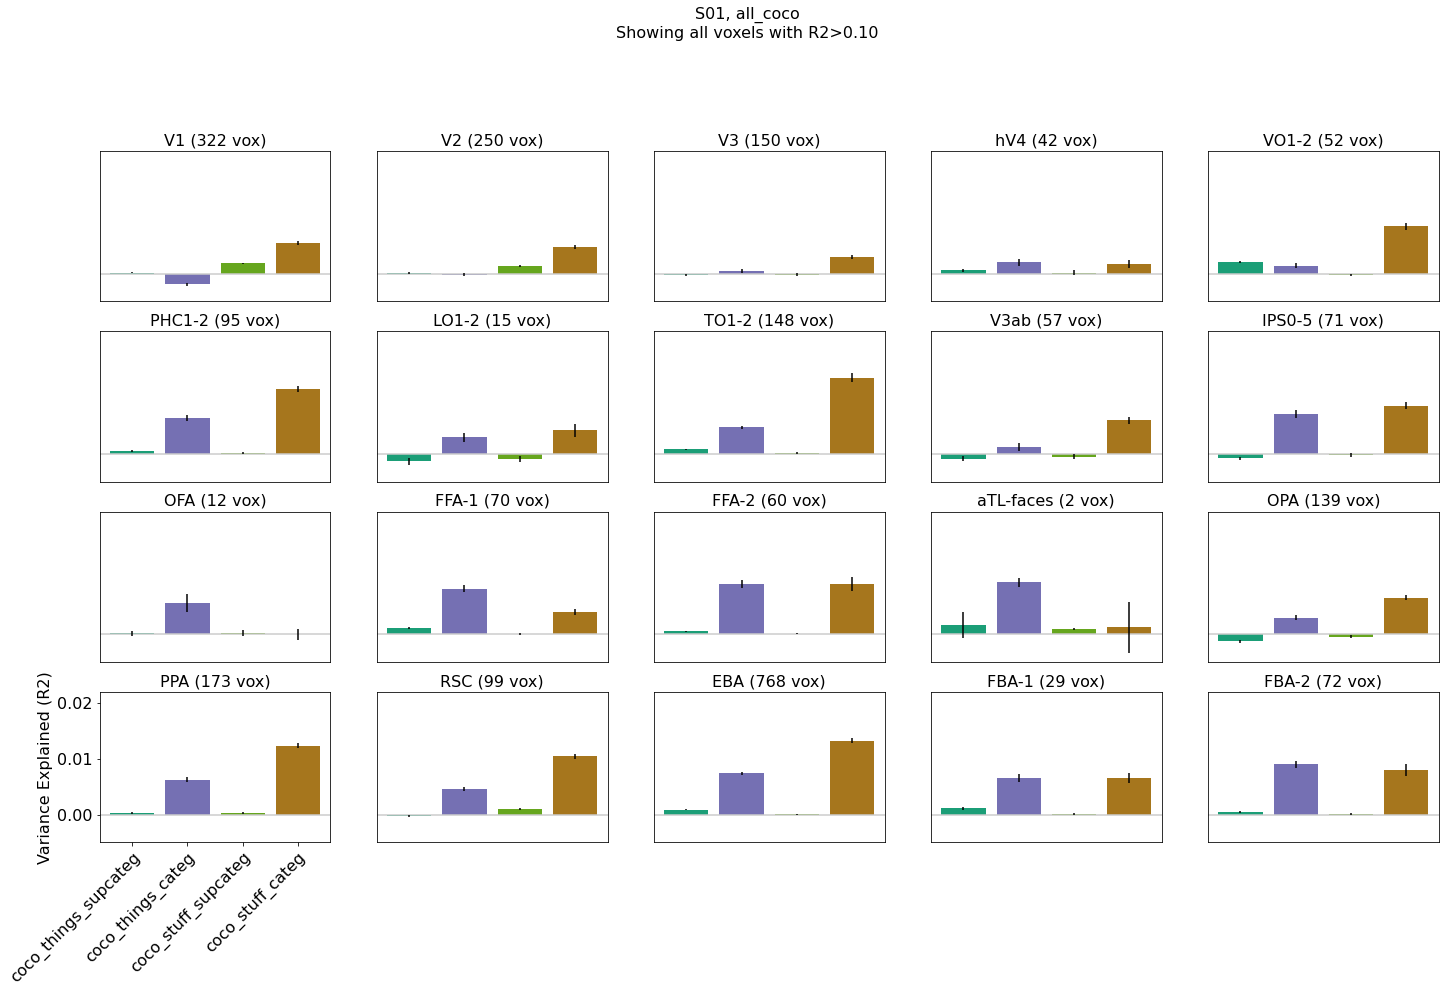

In [23]:
ppinds = [2,4,6,8]

skip_inds = [10,11,15,23]

ve_names = [out[0]['partial_version_names'][pp].split('leave_out_semantic_')[1] for pp in ppinds]
var_expl = np.tile(out[0]['val_r2'][:,0:1], [1,4]) - out[0]['val_r2'][:,ppinds]

colors = cm.Dark2(np.linspace(0,1,5))
# colors = np.flipud(colors)

r2_thresh = 0.10
inds2use = out[0]['val_r2'][:,0]>r2_thresh

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.005, 0.022])
plot_utils.create_roi_subplots(var_expl, inds2use, bp, roi_def=roi_def, skip_inds=skip_inds,\
                    suptitle='S%02d, %s\nShowing all voxels with R2>%.2f'%(subjects[0], fitting_type, r2_thresh))
plt.gcf().subplots_adjust(bottom=0.4)


In [29]:
out['partial_version_names']

['full_combined_model',
 'just_semantic_coco_things_supcateg',
 'leave_out_semantic_coco_things_supcateg',
 'just_semantic_coco_things_categ',
 'leave_out_semantic_coco_things_categ',
 'just_semantic_coco_stuff_supcateg',
 'leave_out_semantic_coco_stuff_supcateg',
 'just_semantic_coco_stuff_categ',
 'leave_out_semantic_coco_stuff_categ']

In [4]:
# Make plots in pycortex for variance partitioning analysis

import cortex

port=13333

vox2plot = out['val_r2'][:,0]>0

best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out, screen_eccen_deg=8.4)

names = ['pRF eccentricity (from alexnet FWRF)', 'pRF angle (from alexnet FWRF)', \
         'pRF size (from alexnet FWRF)', \
        'R2 concat']
maps = [best_ecc_deg, best_angle_deg, best_size_deg, np.sqrt(out['val_r2'][:,0])]
cmaps = ['PRGn', 'Retinotopy_RYBCR', 'PRGn', 'PuBu']
mins = [0,0,0, 0]
maxes = [9, 360, 9, 0.8]


ppinds = [1,3,5,7]

names += ['R2: %s alone'%out['partial_version_names'][pp].split('just_semantic_')[1] for pp in ppinds]
maps += [np.sqrt(out['val_r2'][:,pp]) for pp in ppinds]
cmaps += ['PuBu', 'PuBu', 'PuBu', 'PuBu']
mins += [0,0,0,0]
maxes += [0.80, 0.80, 0.80, 0.80]

ppinds = [2,4,6,8]
ve_names = [out['partial_version_names'][pp].split('leave_out_semantic_')[1] for pp in ppinds]
var_expl = np.tile(out['val_r2'][:,0:1], [1,4]) - out['val_r2'][:,ppinds]
max_ind = np.argmax(var_expl, axis=1).astype(np.float32)

maps += [max_ind+1] + [np.sqrt(var_expl[:,fi]) for fi in range(var_expl.shape[1])]
names += ['Prefered feature type (based on unique var)'] + ve_names
cmaps += ['plasma_r', 'PuBu', 'PuBu', 'PuBu', 'PuBu']
mins += [0,0,0,0,0]
maxes += [4, 0.20, 0.20, 0.20, 0.20]

plot_utils.plot_maps_pycortex(maps, names, subject, out, roi_def=roi_def, vox2plot=vox2plot,\
                              fitting_type=fitting_type, \
                              port=port, cmaps=cmaps, mins=mins, maxes=maxes)

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  
/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in sqrt
/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in sqrt


Data is in 3d volume space
navigate browser to: 127.0.0.1:13333
Started server on port 13333


In [21]:
np.any(np.isnan(vox2plot))

False